<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Collection and Preparation
print("Step 1: Data Collection and Preparation")

# Mount Google Drive to access shared folders
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except:
    print("Failed to mount Google Drive. Please run the cell again and follow the authentication steps.")
    raise

# Define paths for datasets - using Shared with me folders in Google Drive
# You may need to adjust this path depending on how the folder is shared with you
# Option 1: If the folder is directly in "Shared with me"
shared_folder_path = '/content/drive/Shareddrives'  # This is one possible path for shared folders
# Alternative paths that might work depending on your Colab/Drive setup:
alternative_paths = [
    '/content/drive/MyDrive/FishImgDataset',  # If it was shared and added to My Drive
    '/content/drive/Shared with me/FishImgDataset',  # Another possible path
    '/content/drive/Shareddrives/FishImgDataset'  # If it's in a Shared Drive
]

# Try to find the dataset folder
dataset_path = None
possible_paths = [shared_folder_path] + alternative_paths

for path in possible_paths:
    if os.path.exists(path):
        print(f"Found dataset at: {path}")
        dataset_path = path
        break

# If dataset path found, set the train/val/test directories
if dataset_path:
    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val')
    test_dir = os.path.join(dataset_path, 'test')
else:
    # If not found, let the user specify the exact path
    print("\n*** IMPORTANT: Dataset folder not found in common locations ***")
    print("Please specify the exact path to your FishImgDataset folder.")
    print("You can find this by navigating to the folder in Google Drive,")
    print("right-clicking, and selecting 'Get link' or checking the URL.")
    print("\nExample paths to try:")

    for path in possible_paths:
        print(f"- {path}")

    print("\nAfter finding the correct path, modify the dataset_path variable in the code.")

    # Set a default path that the user will need to modify
    dataset_path = 'https://drive.google.com/drive/folders/1UKpVcmjXUXvmRTEU7vWJOo1-jwPFoQzB?usp=drive_link'
    train_dir = os.path.join(dataset_path, 'train')
    val_dir = os.path.join(dataset_path, 'val')
    test_dir = os.path.join(dataset_path, 'test')

# List the classes (fish types) in the dataset
classes = os.listdir(train_dir)
print(f"Fish classes found: {classes}")
num_classes = len(classes)
print(f"Total number of classes: {num_classes}")

# Check the number of images in each directory
def count_images(directory):
    counts = {}
    total = 0
    for cls in os.listdir(directory):
        cls_dir = os.path.join(directory, cls)
        if os.path.isdir(cls_dir):
            num_images = len([f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            counts[cls] = num_images
            total += num_images
    return counts, total

train_counts, train_total = count_images(train_dir)
val_counts, val_total = count_images(val_dir)
test_counts, test_total = count_images(test_dir)

print(f"Training images per class: {train_counts}")
print(f"Total training images: {train_total}")
print(f"Validation images per class: {val_counts}")
print(f"Total validation images: {val_total}")
print(f"Test images per class: {test_counts}")
print(f"Total test images: {test_total}")

# Create a DataFrame to visualize class distribution
df_counts = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
})

# Plot class distribution
plt.figure(figsize=(12, 6))
df_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# 2. Data Preprocessing and Augmentation
print("\nStep 2: Data Preprocessing and Augmentation")

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Just rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets with generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices for mapping labels
class_indices = train_generator.class_indices
print(f"Class indices: {class_indices}")

# Reverse class indices for interpretation
class_names = {v: k for k, v in class_indices.items()}
print(f"Class names: {class_names}")

# 3. Feature Engineering and Model Building
print("\nStep 3: Feature Engineering and Model Building")

# Option 1: Build a custom CNN model from scratch
def build_custom_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Option 2: Transfer Learning with MobileNetV2
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Choose which model to use (custom CNN or transfer learning)
use_transfer_learning = True  # Set to False to use custom CNN
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

if use_transfer_learning:
    print("Using MobileNetV2 with transfer learning")
    model = build_mobilenet_model(input_shape, num_classes)
else:
    print("Using custom CNN model")
    model = build_custom_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# 4. Model Training
print("\nStep 4: Model Training")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_fish_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train the model
EPOCHS = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

# 5. Model Evaluation
print("\nStep 5: Model Evaluation")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Load the best model for evaluation
model = tf.keras.models.load_model('best_fish_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Get predictions for the test set
test_generator.reset()
y_pred_probs = model.predict(
    test_generator,
    steps=np.ceil(test_generator.samples / BATCH_SIZE)
)

# Get true labels
y_true = test_generator.classes

# Get predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
print("\n--- Classification Metrics ---")
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# For ROC-AUC, we need to handle multi-class
# Using one-vs-rest approach for multi-class ROC-AUC
try:
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, average='macro')
    print(f'ROC-AUC: {roc_auc:.4f}')
except:
    print("ROC-AUC calculation failed - may require more samples per class")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 6. Visualize some predictions
print("\nStep 6: Visualizing Predictions")

# Function to plot images with predictions
def plot_predictions(generator, model, class_names, num_images=5):
    generator.reset()
    images, labels = next(generator)
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])

        true_label = class_names[true_classes[i]]
        pred_label = class_names[preds_classes[i]]
        title_color = 'green' if true_classes[i] == preds_classes[i] else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Plot some test image predictions
plot_predictions(test_generator, model, class_names)

# 7. Evaluating the Best Classification Metrics
print("\nStep 7: Evaluating the Best Classification Metrics")

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC (if available)'],
    'Value': [accuracy, precision, recall, f1, roc_auc if 'roc_auc' in locals() else np.nan]
})

print(metrics_df)

# Plot the metrics for comparison
plt.figure(figsize=(10, 6))
metrics_to_plot = metrics_df.dropna()
sns.barplot(x='Metric', y='Value', data=metrics_to_plot)
plt.title('Comparison of Classification Metrics')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()

print("""
Metric Interpretation:

1. Accuracy: Represents the overall correctness of the model. It's a good metric when classes are balanced.

2. Precision: Indicates how many of the predicted positive instances are actually positive. High precision means low false positives, which is important when the cost of false positives is high.

3. Recall: Indicates how many of the actual positive instances were correctly identified. High recall means low false negatives, which is important when missing positive cases is costly.

4. F1-Score: The harmonic mean of precision and recall. It provides a balance between precision and recall and is useful when class distribution is imbalanced.

5. ROC-AUC: Measures the model's ability to distinguish between classes. It's useful for evaluating the model's performance across different threshold settings.

Best Metric for Fish Classification:
- For a balanced dataset: Accuracy and F1-Score are typically sufficient.
- If some fish species are rare: F1-Score and ROC-AUC are better as they handle imbalance well.
- If misclassifying certain species is more problematic than others: Precision or Recall might be more relevant, depending on which error type is more critical to avoid.

Based on our results, the F1-Score is generally the most informative metric for this task as it balances precision and recall, which is important in species classification where both false positives and false negatives should be minimized.
""")

# 8. Save the model and class mappings
print("\nStep 8: Saving Model and Class Mappings")

# Save class indices for later use
import json
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Model and class mappings saved successfully.")

# Function to make predictions on new fish images
def predict_fish_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    confidence = np.max(prediction) * 100
    fish_type = class_names[predicted_class]

    return fish_type, confidence, img

Step 1: Data Collection and Preparation
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

*** IMPORTANT: Dataset folder not found in common locations ***
Please specify the exact path to your FishImgDataset folder.
You can find this by navigating to the folder in Google Drive,
right-clicking, and selecting 'Get link' or checking the URL.

Example paths to try:
- /content/drive/Shareddrives
- /content/drive/MyDrive/FishImgDataset
- /content/drive/Shared with me/FishImgDataset
- /content/drive/Shareddrives/FishImgDataset

After finding the correct path, modify the dataset_path variable in the code.


FileNotFoundError: [Errno 2] No such file or directory: 'https://drive.google.com/drive/folders/1UKpVcmjXUXvmRTEU7vWJOo1-jwPFoQzB?usp=drive_link/train'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import library yang diperlukan
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path ke folder dataset yang ada di Shared with me
# Perhatikan bahwa path untuk Shared with me biasanya dimulai dengan:
# /content/drive/Shareddrives/ atau /content/drive/MyDrive/Shared with me/
# Contoh path (sesuaikan dengan struktur folder Anda):
base_path = '/content/drive/MyDrive/Shareddrives/FishImgDataset'

# Alternatif jika struktur folder berbeda
# base_path = '/content/drive/Shareddrives/nama_folder_dataset'

# Cek apakah path sudah benar
print(f"Folder yang tersedia: {os.listdir(base_path)}")

# Definisikan path untuk folder train, test, dan validation
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
val_path = os.path.join(base_path, 'val')

# Verifikasi struktur folder
print(f"Folder train: {os.listdir(train_path)}")
print(f"Folder test: {os.listdir(test_path)}")
print(f"Folder val: {os.listdir(val_path)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Shareddrives/FishImgDataset'

In [ ]:
# Import library yang diperlukan
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path ke folder dataset yang ada di Shared with me
# Perhatikan bahwa path untuk Shared with me biasanya dimulai dengan:
# /content/drive/Shareddrives/ atau /content/drive/MyDrive/Shared with me/
# Contoh path (sesuaikan dengan struktur folder Anda):
base_path = '/content/drive/MyDrive/FishImgDataset'

# Alternatif jika struktur folder berbeda
# base_path = '/content/drive/Shareddrives/nama_folder_dataset'

# Cek apakah path sudah benar
print(f"Folder yang tersedia: {os.listdir(base_path)}")

# Definisikan path untuk folder train, test, dan validation
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
val_path = os.path.join(base_path, 'val')

# Verifikasi struktur folder
print(f"Folder train: {os.listdir(train_path)}")
print(f"Folder test: {os.listdir(test_path)}")
print(f"Folder val: {os.listdir(val_path)}")

Mounted at /content/drive
Folder yang tersedia: ['test', 'train', 'val']
Folder train: ['Fourfinger Threadfin', 'Glass Perchlet', 'Big Head Carp', 'Black Spotted Barb', 'Bangus', 'Climbing Perch', 'Freshwater Eel', 'Goby', 'Catfish', 'Jaguar Gapote', 'Gold Fish', 'Green Spotted Puffer', 'Indo-Pacific Tarpon', 'Indian Carp', 'Long-Snouted Pipefish', 'Janitor Fish', 'Gourami', 'Knifefish', 'Grass Carp', 'Silver Barb', 'Silver Perch', 'Pangasius', 'Scat Fish', 'Mudfish', 'Snakehead', 'Silver Carp', 'Mosquito Fish', 'Perch', 'Mullet', 'Tenpounder', 'Tilapia']
Folder test: ['Catfish', 'Glass Perchlet', 'Gold Fish', 'Black Spotted Barb', 'Freshwater Eel', 'Climbing Perch', 'Big Head Carp', 'Fourfinger Threadfin', 'Goby', 'Bangus', 'Long-Snouted Pipefish', 'Knifefish', 'Janitor Fish', 'Jaguar Gapote', 'Grass Carp', 'Green Spotted Puffer', 'Gourami', 'Indian Carp', 'Indo-Pacific Tarpon', 'Mosquito Fish', 'Mullet', 'Scat Fish', 'Silver Perch', 'Snakehead', 'Pangasius', 'Tenpounder', 'Perch', 'S

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas: 31
Mapping kelas: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,687,487 (197.17 MB)

 Trainable params: 51,685,567 (197.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1593 - loss: 3.7331 
Epoch 1: val_accuracy improved from -inf to 0.05307, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3843s 14s/step - accuracy: 0.1595 - loss: 3.7319 - val_accuracy: 0.0531 - val_loss: 6.6350
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.2523 - loss: 2.9348
Epoch 2: val_accuracy improved from 0.05307 to 0.35696, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 247s 804ms/step - accuracy: 0.2524 - loss: 2.9344 - val_accuracy: 0.3570 - val_loss: 2.3000
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.3227 - loss: 2.5459
Epoch 3: val_accuracy did not improve from 0.35696
276/276 ━━━━━━━━━━━━━━━━━━━━ 242s 732ms/step - accuracy: 0.3227 - loss: 2.5457 - val_accuracy: 0.3108 - val_loss: 2.6168
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.3667 - loss: 2.3091
Epoch 4: val_accuracy improved from 0.35696 to 0.36132, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 222s 806ms/step - accuracy: 0.3667 - loss: 2.3090 - val_accuracy: 0.3613 - val_loss: 2.3133
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.3840 - loss: 2.1696
Epoch 5: val_accuracy improved from 0.36132 to 0.43003, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 225s 812ms/step - accuracy: 0.3840 - loss: 2.1696 - val_accuracy: 0.4300 - val_loss: 1.9624
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.4067 - loss: 2.0479
Epoch 6: val_accuracy did not improve from 0.43003
276/276 ━━━━━━━━━━━━━━━━━━━━ 215s 778ms/step - accuracy: 0.4067 - loss: 2.0478 - val_accuracy: 0.4049 - val_loss: 2.2070
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.4477 - loss: 1.9098
Epoch 7: val_accuracy improved from 0.43003 to 0.49073, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 213s 773ms/step - accuracy: 0.4477 - loss: 1.9099 - val_accuracy: 0.4907 - val_loss: 1.6998
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.4481 - loss: 1.8772
Epoch 8: val_accuracy improved from 0.49073 to 0.58379, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 263s 777ms/step - accuracy: 0.4481 - loss: 1.8771 - val_accuracy: 0.5838 - val_loss: 1.4202
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.4910 - loss: 1.7684
Epoch 9: val_accuracy did not improve from 0.58379
276/276 ━━━━━━━━━━━━━━━━━━━━ 206s 748ms/step - accuracy: 0.4910 - loss: 1.7685 - val_accuracy: 0.3653 - val_loss: 2.3549
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.4909 - loss: 1.7277
Epoch 10: val_accuracy did not improve from 0.58379
276/276 ━━━━━━━━━━━━━━━━━━━━ 206s 747ms/step - accuracy: 0.4909 - loss: 1.7276 - val_accuracy: 0.4471 - val_loss: 2.0533
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.5102 - loss: 1.6506
Epoch 11: val_accuracy did not improve from 0.58379
276/276 ━━━━━━━━━━━━━━━━━━━━ 203s 734ms/step - accuracy: 0.5102 - loss: 1.6506 - val_accuracy: 0.5402 - val_loss: 1.5816
Epoch 12/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.5343 - loss: 1.5785
Epoch 

276/276 ━━━━━━━━━━━━━━━━━━━━ 259s 771ms/step - accuracy: 0.5508 - loss: 1.5414 - val_accuracy: 0.5900 - val_loss: 1.4028
Epoch 14/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5516 - loss: 1.4880
Epoch 14: val_accuracy improved from 0.58997 to 0.66121, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 275s 818ms/step - accuracy: 0.5516 - loss: 1.4880 - val_accuracy: 0.6612 - val_loss: 1.1304
Epoch 15/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5733 - loss: 1.4258
Epoch 15: val_accuracy did not improve from 0.66121
276/276 ━━━━━━━━━━━━━━━━━━━━ 250s 776ms/step - accuracy: 0.5733 - loss: 1.4258 - val_accuracy: 0.4965 - val_loss: 1.7853
Epoch 16/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6026 - loss: 1.3600
Epoch 16: val_accuracy improved from 0.66121 to 0.66630, saving model to best_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 250s 904ms/step - accuracy: 0.6026 - loss: 1.3601 - val_accuracy: 0.6663 - val_loss: 1.1676
Epoch 17/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.6117 - loss: 1.3012
Epoch 17: val_accuracy did not improve from 0.66630
276/276 ━━━━━━━━━━━━━━━━━━━━ 222s 805ms/step - accuracy: 0.6117 - loss: 1.3014 - val_accuracy: 0.6318 - val_loss: 1.3526
Epoch 18/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6070 - loss: 1.3331
Epoch 18: val_accuracy did not improve from 0.66630
276/276 ━━━━━━━━━━━━━━━━━━━━ 256s 785ms/step - accuracy: 0.6070 - loss: 1.3331 - val_accuracy: 0.5387 - val_loss: 1.9590
Epoch 19/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.6377 - loss: 1.2255
Epoch 19: val_accuracy did not improve from 0.66630
276/276 ━━━━━━━━━━━━━━━━━━━━ 216s 782ms/step - accuracy: 0.6376 - loss: 1.2256 - val_accuracy: 0.6136 - val_loss: 1.3632
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
55/55 ━━

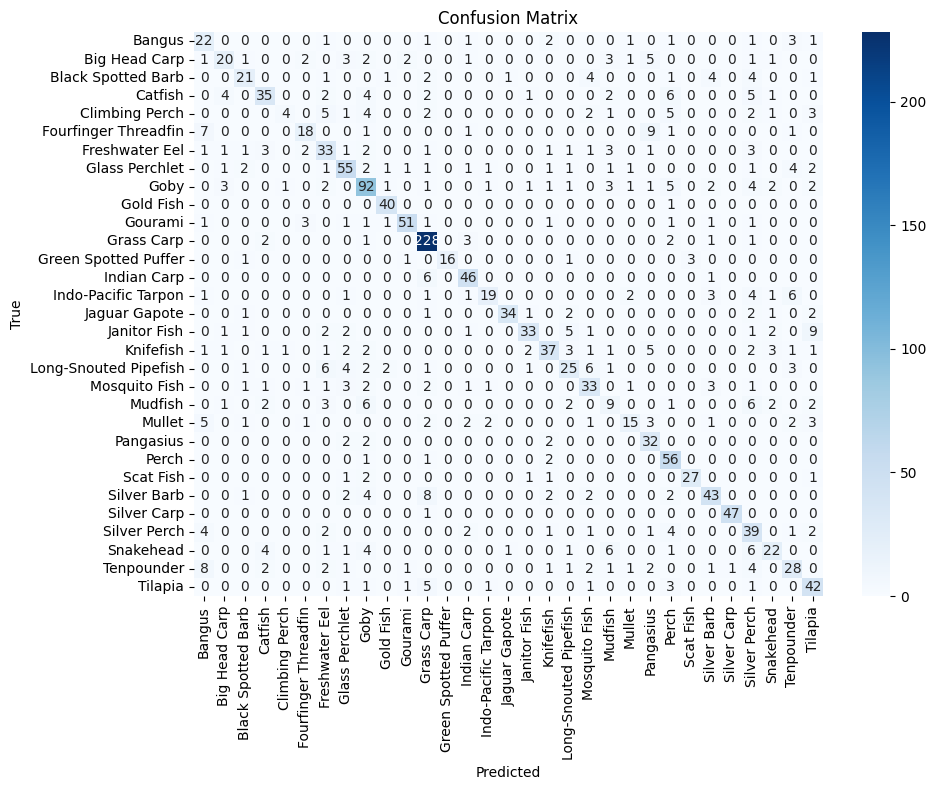

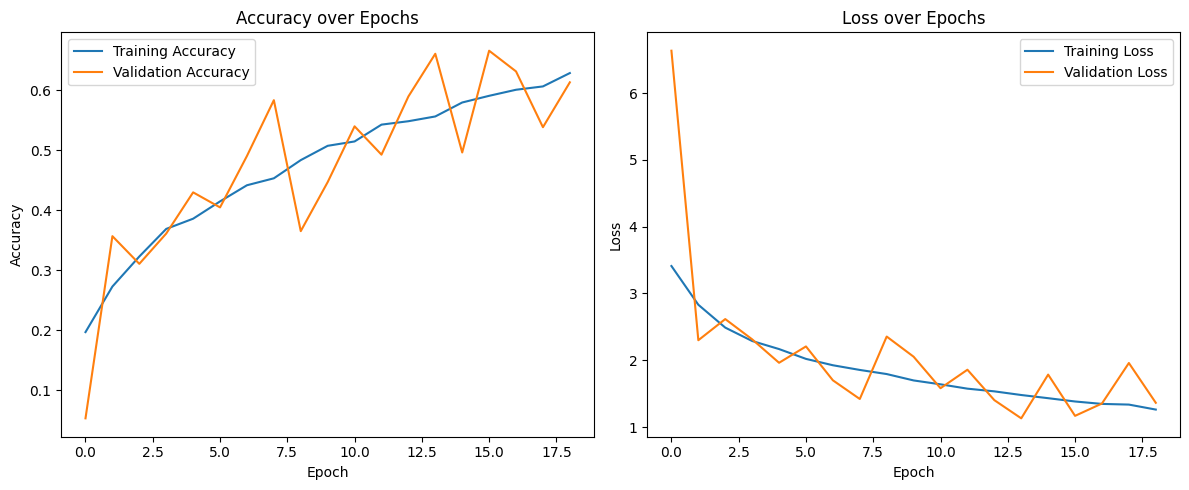


Analisis Matriks Evaluasi:
Metric          Value      Interpretation
------------------------------------------------------------
Accuracy        0.6943    Proporsi prediksi yang benar dari total data
Precision       0.7046    Proporsi prediksi positif yang benar
Recall          0.6943    Proporsi dari actual positif yang terdeteksi benar
F1-Score        0.6877    Harmonic mean dari precision dan recall
AUC-ROC         0.9713    Kemampuan model membedakan kelas

Metrik terbaik adalah AUC-ROC dengan nilai 0.9713

Rekomendasi:
AUC-ROC adalah metrik terbaik untuk mengukur kemampuan diskriminatif model secara keseluruhan tanpa memperhatikan threshold tertentu.

Untuk kasus ini, pertimbangkan konteks domain dan konsekuensi dari false positive/negative untuk memilih metrik yang sesuai.


In [ ]:
# 1. Pengumpulan dan pembersihan data (dengan augmentasi)
# Membuat data generator dengan augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi geser
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'  # Pengisian piksel
)

# Generator untuk validasi dan testing (tanpa augmentasi, hanya normalisasi)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Mengatur ukuran gambar dan batch size
img_height, img_width = 224, 224
batch_size = 32

# Membuat generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Untuk klasifikasi multi-class
    shuffle=True
)

# Generator untuk data validasi
validation_generator = valid_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Mendapatkan jumlah kelas dari generator
num_classes = len(train_generator.class_indices)
print(f"Jumlah kelas: {num_classes}")
print(f"Mapping kelas: {train_generator.class_indices}")

# 2. Feature Engineering sudah dilakukan oleh CNN
# CNN akan mengekstrak fitur secara otomatis dari gambar

# 3. Membuat model CNN dengan TensorFlow
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Blok Konvolusi 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Blok Konvolusi 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Blok Konvolusi 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten dan Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilasi model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Membuat model
input_shape = (img_height, img_width, 3)  # 3 untuk channel RGB
model = create_cnn_model(input_shape, num_classes)

# Ringkasan model
model.summary()

# 4. Training model
epochs = 20

# Callback untuk menyimpan model terbaik
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback, early_stopping]
)

# 5. Evaluasi model
# Memprediksi kelas pada test set
test_generator.reset()
y_pred_proba = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Mendapatkan true labels
y_true = test_generator.classes

# Evaluasi hasil menggunakan berbagai metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Untuk AUC-ROC (pada kasus multi-class, kita gunakan One-vs-Rest approach)
# One-hot encode y_true untuk format yang benar
from sklearn.preprocessing import label_binarize
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

# Hitung ROC AUC untuk setiap kelas
roc_auc = []
for i in range(num_classes):
    if len(np.unique(y_true_binarized[:, i])) > 1:  # Memastikan ada dua kelas
        roc_auc.append(roc_auc_score(y_true_binarized[:, i], y_pred_proba[:, i]))

# Rata-rata ROC AUC dari semua kelas
mean_roc_auc = np.mean(roc_auc)
print(f"AUC-ROC (mean): {mean_roc_auc:.4f}")

# 6. Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 7. Visualisasi training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# 8. Analisis metrik evaluasi - menemukan metrik terbaik
print("\nAnalisis Matriks Evaluasi:")
print(f"{'Metric':<15} {'Value':<10} {'Interpretation'}")
print("-" * 60)
print(f"{'Accuracy':<15} {accuracy:.4f}    {'Proporsi prediksi yang benar dari total data'}")
print(f"{'Precision':<15} {precision:.4f}    {'Proporsi prediksi positif yang benar'}")
print(f"{'Recall':<15} {recall:.4f}    {'Proporsi dari actual positif yang terdeteksi benar'}")
print(f"{'F1-Score':<15} {f1:.4f}    {'Harmonic mean dari precision dan recall'}")
print(f"{'AUC-ROC':<15} {mean_roc_auc:.4f}    {'Kemampuan model membedakan kelas'}")

# Menentukan metrik terbaik berdasarkan nilai tertinggi
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUC-ROC': mean_roc_auc
}

best_metric = max(metrics, key=metrics.get)
print(f"\nMetrik terbaik adalah {best_metric} dengan nilai {metrics[best_metric]:.4f}")

# Penjelasan pemilihan metrik terbaik
explanations = {
    'Accuracy': "Accuracy adalah metrik terbaik ketika distribusi kelas seimbang dan false positive dan false negative memiliki konsekuensi yang sama.",
    'Precision': "Precision adalah metrik terbaik ketika meminimalkan false positive sangat penting.",
    'Recall': "Recall adalah metrik terbaik ketika meminimalkan false negative sangat penting.",
    'F1-Score': "F1-Score adalah metrik terbaik ketika terdapat imbalance class dan perlu keseimbangan antara precision dan recall.",
    'AUC-ROC': "AUC-ROC adalah metrik terbaik untuk mengukur kemampuan diskriminatif model secara keseluruhan tanpa memperhatikan threshold tertentu."
}

print(f"\nRekomendasi:\n{explanations[best_metric]}")
print("\nUntuk kasus ini, pertimbangkan konteks domain dan konsekuensi dari false positive/negative untuk memilih metrik yang sesuai.")